### Load data

In [1]:
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import numpy as np

In [56]:
df = spark.read.csv('../data/df_model_final.csv',header=True,inferSchema=True).cache()
df


DataFrame[uid: int, label: int, freq_P_last_1: int, freq_P_last_3: int, freq_P_last_7: int, freq_P_last_14: int, freq_P_last_30: int, freq_D_last_1: int, freq_D_last_3: int, freq_D_last_7: int, freq_D_last_14: int, freq_D_last_30: int, freq_S_last_1: int, freq_S_last_3: int, freq_S_last_7: int, freq_S_last_14: int, freq_S_last_30: int, device_type: int]

### Prepare training data

In [3]:
selected_features = df.columns
selected_features.remove('uid')
selected_features.remove('label')
selected_features.remove('device_type')
selected_features

['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30']

In [4]:
# specific step for spark, convert the features values into a vector as a new feature
# when build the model, function will use this 'features' and 'label' to fit
assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features")
data = assembler.transform(df)

# train test split
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

### Evaluate performance

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

### Fit logistic regression

In [86]:
ml = LogisticRegression(maxIter=200, regParam=0.01) # reParam is the regularization strength
model = ml.fit(train)

### Predict and Evaluate performance

In [52]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()


+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.32521038693560...|       1.0|    0|    (15,[4],[216.0])|
|[0.31605644851073...|       1.0|    1|(15,[3,4],[12.0,1...|
|[0.77763631890578...|       0.0|    0|(15,[2,3,4],[50.0...|
|[0.59840078691713...|       0.0|    1|(15,[0,1,2,3,4,9,...|
|[0.78740034878927...|       0.0|    0|[23.0,53.0,58.0,6...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.86404890852285...|       0.0|    0|(15,[0,1,2,3,4,9]...|
|[0.99924887956500...|       0.0|    0|[85.0,116.0,179.0...|
|[0.92693620006547...|       0.0|    0|[0.0,76.0,130.0,2...|
|[0.33544298196953...|       1.0|    0|(15,[3,4,9,14],[1...|

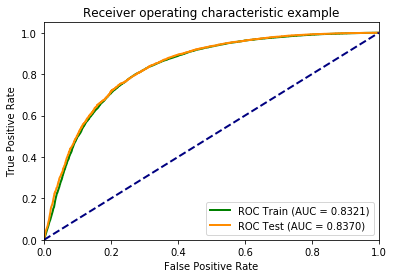

In [53]:
y_train = res_train['label']
# there are two numbers in the res_train['probability']
# choose the second one (the probability of label as 1) to use
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

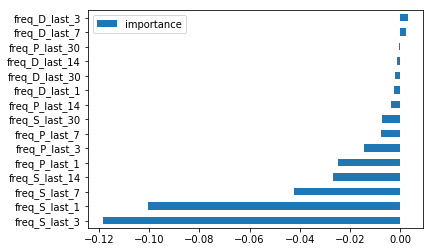

In [88]:
df_feature_importance = pd.DataFrame()
df_feature_importance['feature'] = selected_features
df_feature_importance['importance'] = model.coefficients
df_feature_importance.sort_values('importance',inplace=True)

ax = df_feature_importance.plot.barh()
t = np.arange(len(df_feature_importance['feature']))
ax.set_yticks(t)
ax.set_yticklabels(df_feature_importance['feature'])
plt.show()

### Random Forest

In [82]:
ml = RandomForestClassifier(labelCol="label", featuresCol="features"
                            ,numTrees=50 # 50
                            ,featureSubsetStrategy="auto"
                            ,impurity='gini'
                            ,maxDepth=12 # 12
                            ,minInstancesPerNode=10
                            ,maxBins=16 # max split
                            )
model = ml.fit(train)

In [83]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.13475606196500...|       1.0|    0|    (15,[4],[216.0])|
|[0.30337275398597...|       1.0|    1|(15,[3,4],[12.0,1...|
|[0.50560105734039...|       0.0|    0|(15,[2,3,4],[50.0...|
|[0.89474837116013...|       0.0|    1|(15,[0,1,2,3,4,9,...|
|[0.92818117655160...|       0.0|    0|[23.0,53.0,58.0,6...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.84537850686345...|       0.0|    0|(15,[0,1,2,3,4,9]...|
|[0.97520912413659...|       0.0|    0|[85.0,116.0,179.0...|
|[0.89145784988586...|       0.0|    0|[0.0,76.0,130.0,2...|
|[0.50659746871384...|       0.0|    0|(15,[3,4,9,14],[1...|

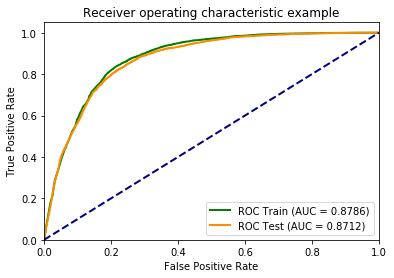

In [84]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

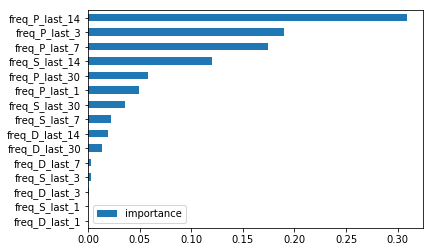

In [85]:
df_feature_importance = pd.DataFrame()
df_feature_importance['feature'] = selected_features
df_feature_importance['importance'] = [i for i in model.featureImportances]
df_feature_importance.sort_values('importance',inplace=True)

ax = df_feature_importance.plot.barh()
t = np.arange(len(df_feature_importance['feature']))
ax.set_yticks(t)
ax.set_yticklabels(df_feature_importance['feature'])
plt.show()

### Gradient Boosting Classifier

In [58]:
ml = GBTClassifier(labelCol="label", featuresCol="features"
                            ,maxIter=100 # 50
                            ,maxDepth=6 # 12
                            ,minInstancesPerNode=10
                            ,maxBins=16 # max split
                            ,stepSize=0.05
                            )
model = ml.fit(train)

In [59]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.11633504946664...|       1.0|    0|    (15,[4],[216.0])|
|[0.26876940398774...|       1.0|    1|(15,[3,4],[12.0,1...|
|[0.49869475843256...|       1.0|    0|(15,[2,3,4],[50.0...|
|[0.78482368989561...|       0.0|    1|(15,[0,1,2,3,4,9,...|
|[0.86807920417427...|       0.0|    0|[23.0,53.0,58.0,6...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.89480469185330...|       0.0|    0|(15,[0,1,2,3,4,9]...|
|[0.97238480576092...|       0.0|    0|[85.0,116.0,179.0...|
|[0.94790631074277...|       0.0|    0|[0.0,76.0,130.0,2...|
|[0.54848394884456...|       0.0|    0|(15,[3,4,9,14],[1...|

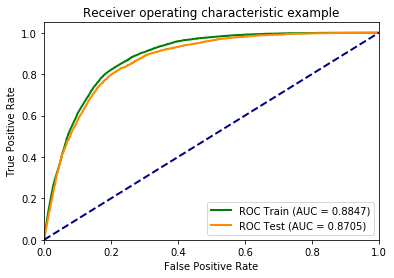

In [80]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

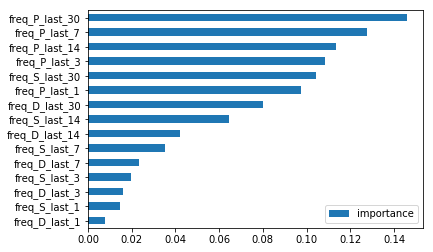

In [81]:
df_feature_importance = pd.DataFrame()
df_feature_importance['feature'] = selected_features
df_feature_importance['importance'] = [i for i in model.featureImportances]
df_feature_importance.sort_values('importance',inplace=True)

ax = df_feature_importance.plot.barh()
t = np.arange(len(df_feature_importance['feature']))
ax.set_yticks(t)
ax.set_yticklabels(df_feature_importance['feature'])
plt.show()